# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import ast
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('shape of azdiaz dataset: {}'.format(azdias.shape))
print('shape of feature summary: {}'.format(feat_info.shape))

shape of azdiaz dataset: (891221, 85)
shape of feature summary: (85, 4)


In [4]:
# print the first few rows of `azdias`
azdias.head(7)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


In [5]:
# print the first few rows of `feat_info`
feat_info.head(7)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]



## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

Number of missing value (naturally) before converting `missing_or_unknown` values:

In [6]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [7]:
# convert missing_or_unknown column's value into list
list_unknown = [val.strip('[]').split(',') for val in feat_info['missing_or_unknown']]
list_unknown[0:10]

[['-1', '0'],
 ['-1', '0', '9'],
 ['-1', '0'],
 ['0'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1'],
 ['-1']]

In [8]:
# convert possible string of number/numeric into numeric
for idx, unknown in enumerate(list_unknown):
    memo = list()
    for value in unknown:
        try:
            is_int = int(value)
        except ValueError:
            memo.append(str(value))
        else:
            memo.append(is_int)
    list_unknown[idx] = memo
list_unknown[:10]

[[-1, 0], [-1, 0, 9], [-1, 0], [0], [-1], [-1], [-1], [-1], [-1], [-1]]

Now, as the `missing_or_unkown` column in feat_info has been converted properly into `list_unknown`. I can use it as reference to convert values in azdias that match values in `list_unknown` based on the name of the `attribute`

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
for idx, val in enumerate(list_unknown):
    if val != ['']:
        azdias.iloc[:, idx] = azdias.iloc[:, idx].replace(val, np.nan)

In [10]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


Number of missing values after converting `missing_or_unknown` values into `np.nan`:

In [11]:
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

> For this purpose, __an outlier__ is defined as a column that most of the values are missing values.

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
dict_missing = {azdias[att].name: azdias[att].isnull().sum() for att in azdias.columns}
dict_missing

{'AGER_TYP': 685843,
 'ALTERSKATEGORIE_GROB': 2881,
 'ANREDE_KZ': 0,
 'CJT_GESAMTTYP': 4854,
 'FINANZ_MINIMALIST': 0,
 'FINANZ_SPARER': 0,
 'FINANZ_VORSORGER': 0,
 'FINANZ_ANLEGER': 0,
 'FINANZ_UNAUFFAELLIGER': 0,
 'FINANZ_HAUSBAUER': 0,
 'FINANZTYP': 0,
 'GEBURTSJAHR': 392318,
 'GFK_URLAUBERTYP': 4854,
 'GREEN_AVANTGARDE': 0,
 'HEALTH_TYP': 111196,
 'LP_LEBENSPHASE_FEIN': 97632,
 'LP_LEBENSPHASE_GROB': 94572,
 'LP_FAMILIE_FEIN': 77792,
 'LP_FAMILIE_GROB': 77792,
 'LP_STATUS_FEIN': 4854,
 'LP_STATUS_GROB': 4854,
 'NATIONALITAET_KZ': 108315,
 'PRAEGENDE_JUGENDJAHRE': 108164,
 'RETOURTYP_BK_S': 4854,
 'SEMIO_SOZ': 0,
 'SEMIO_FAM': 0,
 'SEMIO_REL': 0,
 'SEMIO_MAT': 0,
 'SEMIO_VERT': 0,
 'SEMIO_LUST': 0,
 'SEMIO_ERL': 0,
 'SEMIO_KULT': 0,
 'SEMIO_RAT': 0,
 'SEMIO_KRIT': 0,
 'SEMIO_DOM': 0,
 'SEMIO_KAEM': 0,
 'SEMIO_PFLICHT': 0,
 'SEMIO_TRADV': 0,
 'SHOPPER_TYP': 111196,
 'SOHO_KZ': 73499,
 'TITEL_KZ': 889061,
 'VERS_TYP': 111196,
 'ZABEOTYP': 0,
 'ALTER_HH': 310267,
 'ANZ_PERSONEN': 73499,

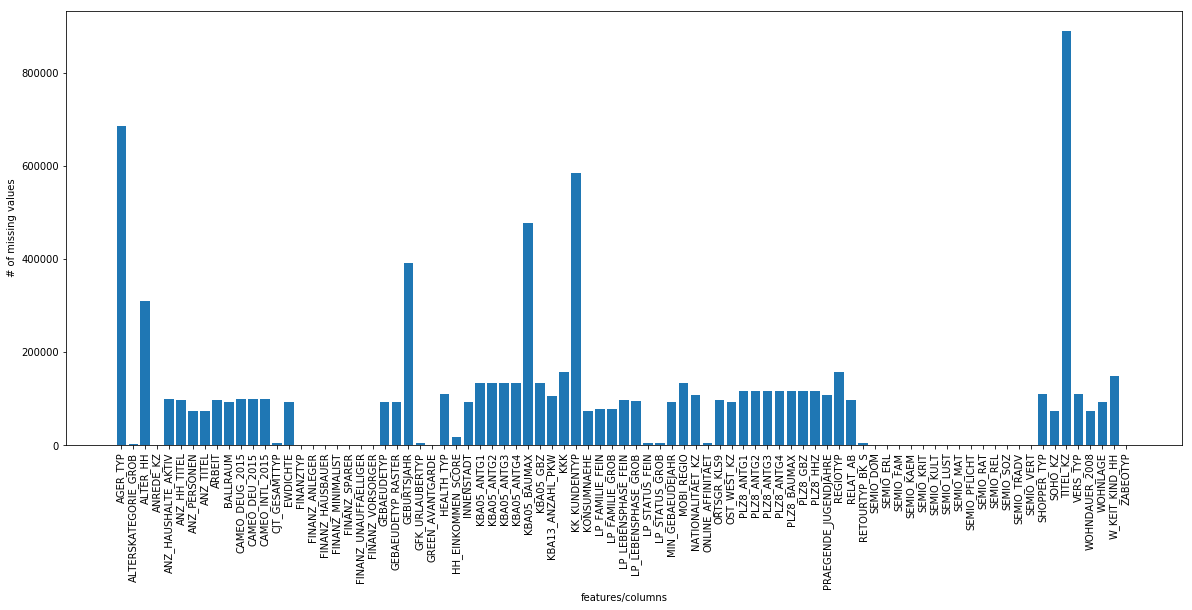

In [13]:
# plot the number of missing values for each feature
lists = list(dict_missing.items())
x, y = zip(*lists)
plt.figure(figsize=(20,8))
plt.bar(x, y)
plt.xticks(rotation='vertical')
plt.xlabel('features/columns')
plt.ylabel('# of missing values')
plt.show()

In [14]:
# determine which column with most values are missing values
outliers_att = []
for att in azdias.columns:
    num_missing = azdias[att].isnull().sum()
    perc = num_missing/azdias.shape[0]
    if perc >= 0.2:
        outliers_att.append(att)
        print(att, perc)

AGER_TYP 0.769554352961
GEBURTSJAHR 0.440202822869
TITEL_KZ 0.997576358726
ALTER_HH 0.348136994079
KK_KUNDENTYP 0.655967487301
KBA05_BAUMAX 0.534686682652


Just for validation, let's plot the distribution of missing values in `outliers_att` list

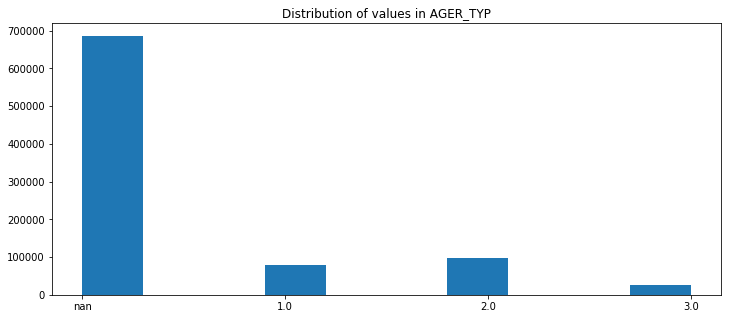

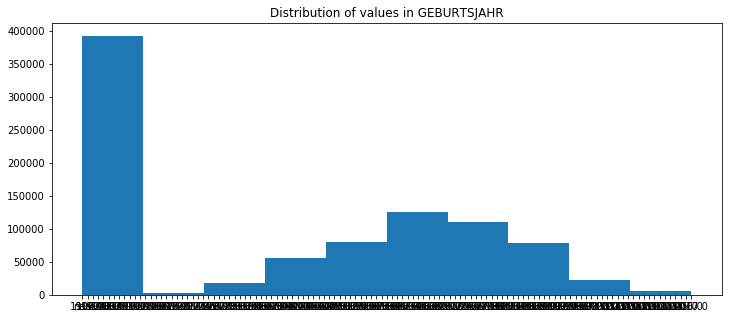

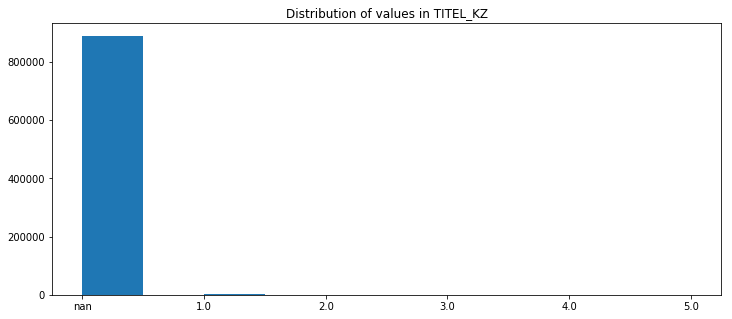

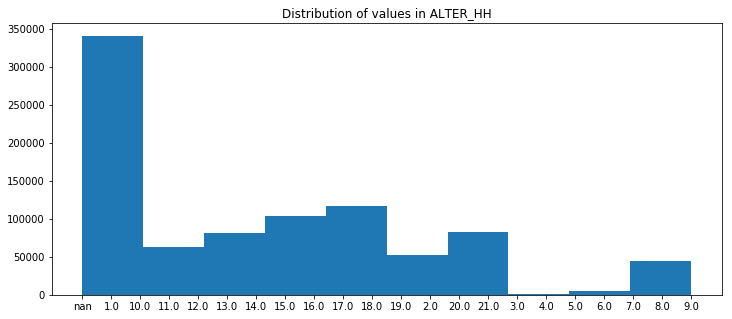

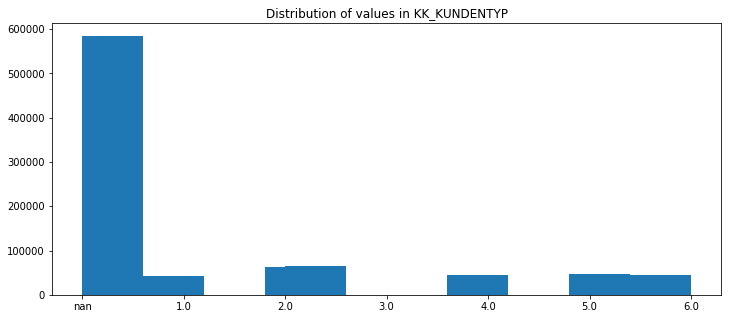

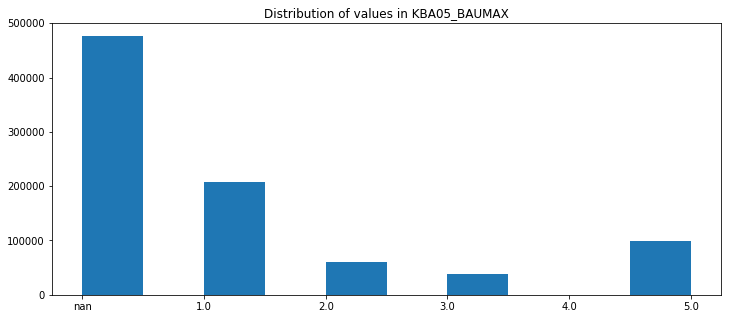

In [15]:
# Investigate patterns in the amount of missing data in each column.
for att in outliers_att:
    plt.figure(figsize=(12,5))
    val_hist = azdias[att].replace(np.nan, 'nan')
    plt.hist(val_hist)
    plt.title('Distribution of values in {}'.format(att))
    plt.show()

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias = azdias.drop(labels=outliers_att, axis=1)

In [17]:
# display first few rows of azdias
print('With shape: {}'.format(azdias.shape))
azdias.head(10)

With shape: (891221, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

The main purpose of this process was assessing missing data in `azdias` table. Although there are already exist missing values, naturally, in `azdias`, `feat_info` provides more information about missing or __unknown__ values that shouldn't be there. Hence, some additional steps below need to be done:

1. Convert information about missing or unknown values in `feat_info`, in `missing_or_unknown` column, such that it can be referred for converting values that match in `azdias` based on particular column.
2. After convert those information, it's time to convert values in `azdias` that match in `feat_info` into `np.nan`. This represents a missing value properly.
3. Some columns turn out have difference number of missing values after previous 2 steps were conducted.
4. Next, from the `bar plot` of number of missing values in each features, yields __six__ columns that most values are missing. Hence, it's considered as __outliers__.
5. Those outliers are then dropped from `azdias` and resulting new `azdias` table with 81 columns/features.
6. In addition, if we look at `PLZ8_ANTG1` until the last column, they share missing values. Hence, it needs more assessment how missing values behave in each row.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?

missing_rows = azdias.isnull().sum(axis=1)
missing_rows.name = 'num_missing'
missing_rows[:5]

0    43
1     0
2     0
3     7
4     0
Name: num_missing, dtype: int64

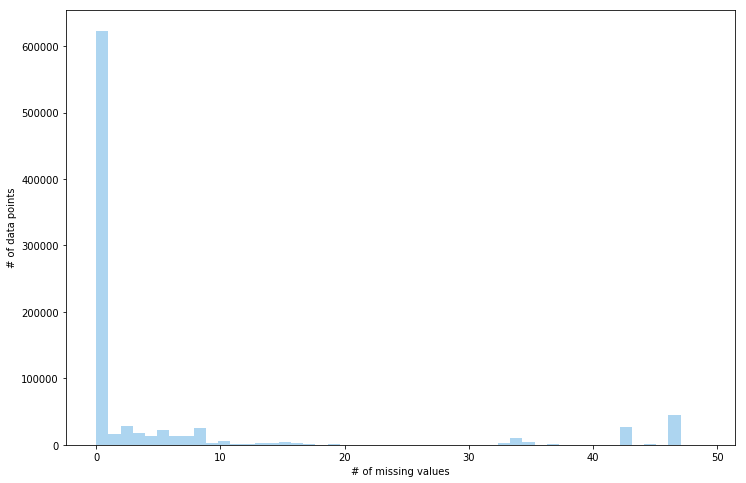

In [19]:
# distribution of number of missing values in each rows
plt.figure(figsize=(12,8))
sns.distplot(missing_rows, color='#3498db', kde=False)
plt.ylabel('# of data points')
plt.xlabel('# of missing values')
plt.show()

In [20]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_more_missing = missing_rows[missing_rows > 10]
azdias_less_missing = missing_rows[missing_rows <= 10]

In [21]:
print(azdias_more_missing.shape, azdias_less_missing.shape)

(111068,) (780153,)


In [22]:
# define the two subsets
subset_more_missing = azdias.loc[azdias_more_missing.index, :]
subset_less_missing = azdias.loc[azdias_less_missing.index, :]

# subset_more_missing.head()
subset_less_missing.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [23]:
# determine non-missing features
non_missing_features = list()
for feat, val in dict_missing.items():
    if val == 0:
        non_missing_features.append(feat)
non_missing_features

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

From list of non-missing columns above, I will check the distribution of their values for column `ANREDE_KZ`, `FINANZ_MINIMALIST`, `FINANZTYP`, `GREEN_AVANTGARDE`, `SEMIO_FAM`, `ZABEOTYP`

In [24]:
check_feat = ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_FAM', 'ZABEOTYP']

In [25]:
# function to plot 2 figures
def compare_subset(feature):
    """Compare the distribution of non-missing features from
    `azdias_more_missing` and `azdias_less_missing`.
    """
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.hist(subset_more_missing[feature])
    plt.title('Histogram of {} in subset with more missing values'.format(feature))
    plt.subplot(122)
    plt.hist(subset_less_missing[feature])
    plt.title('Histogram of {} in subset with less missing values'.format(feature))
    plt.show()

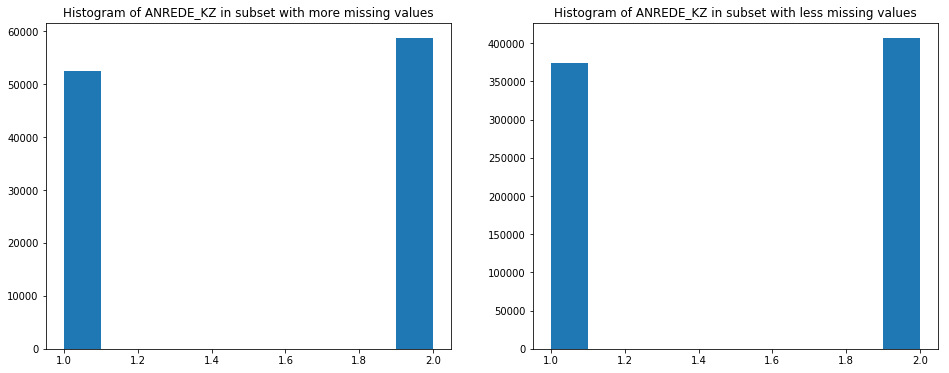

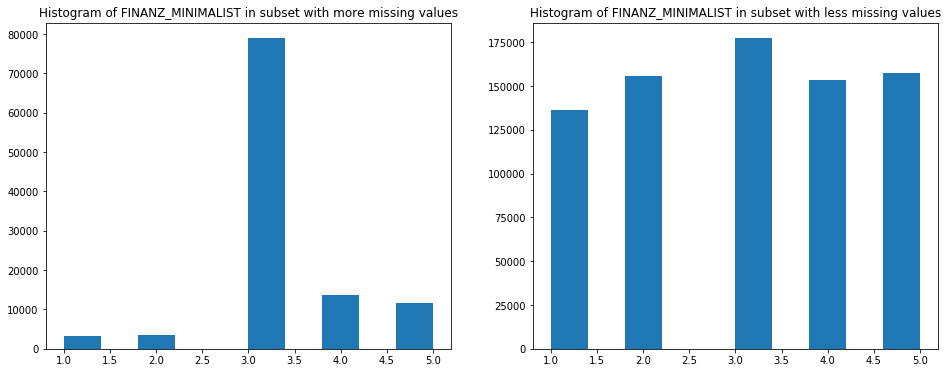

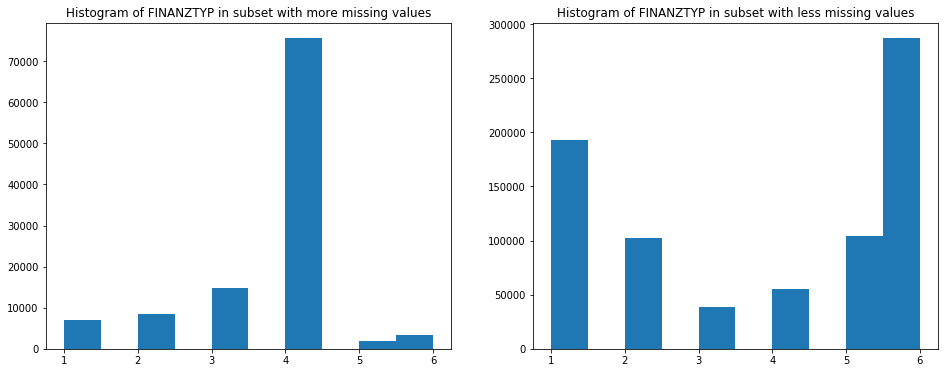

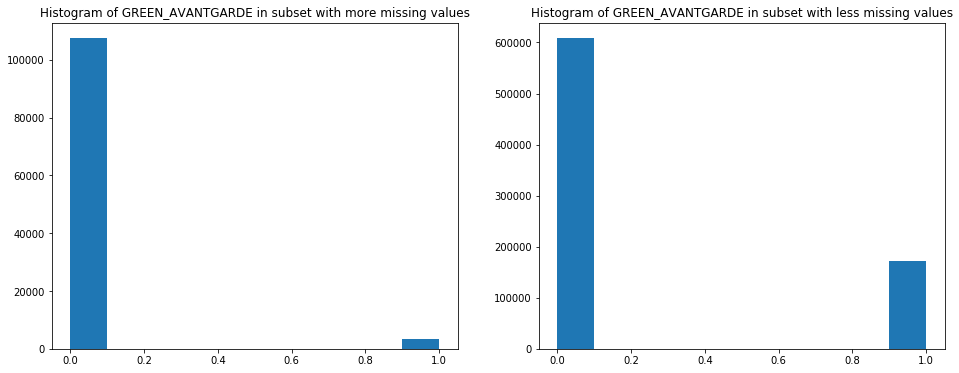

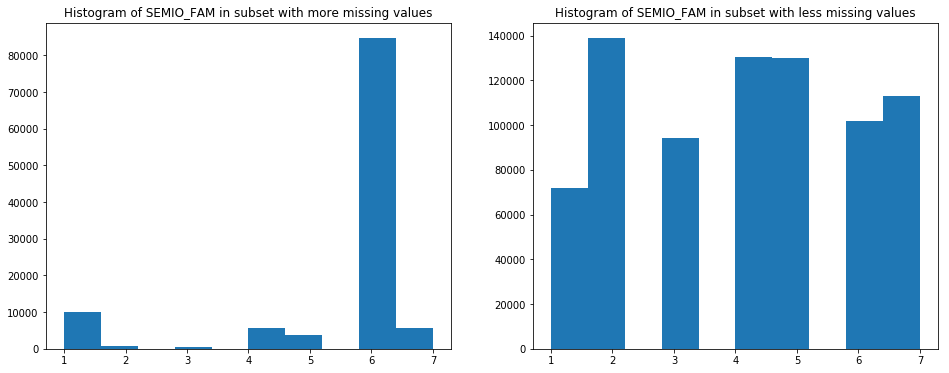

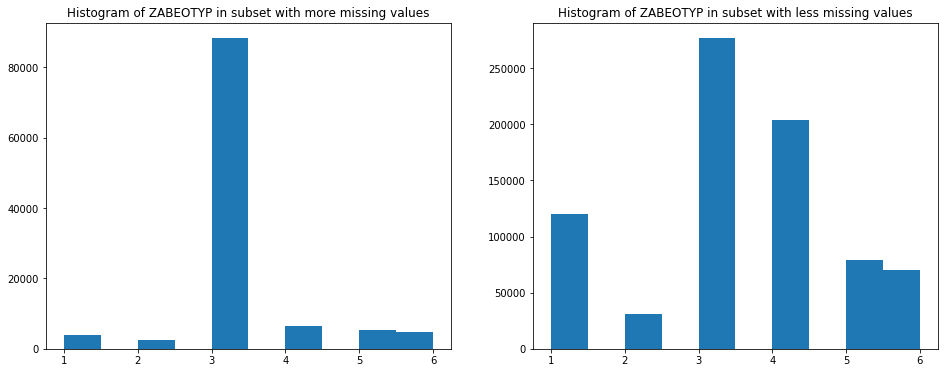

In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
for feat in check_feat:
    compare_subset(feat)

#### Discussion 1.1.3: Assess Missing Data in Each Row

This step is about assessing missing data in each row of `azdias`. The purpose is to observe how missing values is distributed and shared between columns for each rows. In order to do that, first we need to determine __a threshold__ for dividing the data into two subset, one with more missing values and the other with few or no missing values. In order to determine the threshold, I plot the distribution of how many missing values in every data points. Based on that plot, I decided to set a threshold to 10, which means `subset_less_missing` is a subset of azdias with less than 10 missing values in every data points.

Then, choosing several non-missing features, that is features that has no missing values in it, I create histograms to compare the value distribution. The result is that data subset with more missing values __behave differently__ compare to data subset with few or no missing values. Hence, it's okay to work with `subset_less_missing` data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# overview of `feat_info`
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


Because features in the `subset_less_missing` is a result of dropping some features in the earlier step, then we don't need to take account those features that are not in the subset. Those subsets are `AGER_TYP`, `TITEL_KZ`, `KK_KUNDENTYP`, and `KBA05_BAUMAX`.

In [28]:
# drop outliers feature from feat_info
for index, feat in enumerate(feat_info.attribute):
    if feat in outliers_att:
        feat_info.drop(index, axis=0, inplace=True)

feat_info.shape

(79, 4)

In [29]:
# kind of data type
feat_info.type.unique()

array(['ordinal', 'categorical', 'mixed', 'numeric'], dtype=object)

In [30]:
# How many features are there of each data type?

feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
categorical_feature = feat_info.loc[feat_info['type']=='categorical', 'attribute']
mixed_feature = feat_info.loc[feat_info['type']=='mixed', 'attribute']
print('categorical features:\n{}'.format(categorical_feature))
print('')
print('mixed features:\n{}'.format(mixed_feature))

categorical features:
2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

mixed features:
15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object


In [32]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

display(subset_less_missing[categorical_feature].head(10))
multilevel = list()
for categoric in list(categorical_feature):
    nuniq = subset_less_missing[categoric].nunique()
    if nuniq > 2:
        multilevel.append(categoric)
        print('multilevel-categorical feature: {}.. with {} values.'.format(categoric, nuniq))

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4,4C
3,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2,2A
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6,6B
5,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,W,8,8C
6,2,5.0,4,12.0,0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,4,1.0,W,4,4A
7,1,3.0,5,9.0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1,8.0,W,2,2D
8,1,3.0,6,3.0,1,1.0,1.0,10.0,5.0,1.0,3.0,0.0,2.0,6,3.0,W,1,1A
9,2,4.0,1,12.0,1,1.0,1.0,3.0,2.0,1.0,3.0,0.0,2.0,4,3.0,W,1,1E
10,2,1.0,6,8.0,0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,2.0,3,1.0,W,9,9D


multilevel-categorical feature: CJT_GESAMTTYP.. with 6 values.
multilevel-categorical feature: FINANZTYP.. with 6 values.
multilevel-categorical feature: GFK_URLAUBERTYP.. with 12 values.
multilevel-categorical feature: LP_FAMILIE_FEIN.. with 11 values.
multilevel-categorical feature: LP_FAMILIE_GROB.. with 5 values.
multilevel-categorical feature: LP_STATUS_FEIN.. with 10 values.
multilevel-categorical feature: LP_STATUS_GROB.. with 5 values.
multilevel-categorical feature: NATIONALITAET_KZ.. with 3 values.
multilevel-categorical feature: SHOPPER_TYP.. with 4 values.
multilevel-categorical feature: ZABEOTYP.. with 6 values.
multilevel-categorical feature: GEBAEUDETYP.. with 7 values.
multilevel-categorical feature: CAMEO_DEUG_2015.. with 9 values.
multilevel-categorical feature: CAMEO_DEU_2015.. with 44 values.


From above, there are several categorical features with multi-values, varies from 3 until 44 values. For simplicity, I will encode those categorical features with more than or equal to 5 values, and drop the rest.

For binary features, there is one feature, `OST_WEST_KZ` that has non-numeric binary values. Hence, this feature also will be encoded using only binary encoding.

In [33]:
# choose categorical to be dropped
dropped_mv = list()
for mv in multilevel:
    if subset_less_missing[mv].nunique() >= 5:
        dropped_mv.append(mv)
        subset_less_missing.drop(mv, axis=1, inplace=True)
        index_categoric = feat_info.loc[feat_info['attribute']==mv].index
        categorical_feature.drop(index_categoric, axis=0, inplace=True)
        
print(subset_less_missing.shape, categorical_feature.shape, len(multilevel))

(780153, 68) (7,) 13


In [34]:
print(f'dropped multilevel features: \n {dropped_mv}')

dropped multilevel features: 
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [35]:
print(f'remaining categorical features:\n{categorical_feature}')

remaining categorical features:
2            ANREDE_KZ
13    GREEN_AVANTGARDE
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
55         OST_WEST_KZ
Name: attribute, dtype: object


In [36]:
# choose categorical to be encoded
binary_nonnumeric = 'OST_WEST_KZ'
categorical_feature.drop(labels=55, inplace=True, axis=0)
print('categorical to be encoded:\n{}'.format(categorical_feature))
print('binary nonnumeric to be encoded:\n{}'.format(binary_nonnumeric))
# reset index of subset_less_missing
subset_less_missing = subset_less_missing.reset_index(drop=True)
display(subset_less_missing[categorical_feature].head(10))
display(subset_less_missing[binary_nonnumeric].head(10))

categorical to be encoded:
2            ANREDE_KZ
13    GREEN_AVANTGARDE
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
Name: attribute, dtype: object
binary nonnumeric to be encoded:
OST_WEST_KZ


,ANREDE_KZ,GREEN_AVANTGARDE,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP
0,2,0,1.0,3.0,1.0,2.0
1,2,1,1.0,2.0,0.0,1.0
2,2,0,1.0,1.0,0.0,1.0
3,1,0,1.0,2.0,0.0,2.0
4,2,0,1.0,0.0,0.0,2.0
5,2,0,1.0,1.0,0.0,1.0
6,1,0,1.0,0.0,0.0,1.0
7,1,1,1.0,3.0,0.0,2.0
8,2,1,1.0,3.0,0.0,2.0
9,2,0,1.0,2.0,0.0,2.0


0    W
1    W
2    W
3    W
4    W
5    W
6    W
7    W
8    W
9    W
Name: OST_WEST_KZ, dtype: object

In [37]:
# encode binary nonnumeric feature using manual mapping
# to numeric dictionary
binary_dict = {'W': 0, 'O': 1}
subset_less_missing['OST_WEST_KZ'] = subset_less_missing['OST_WEST_KZ'].map(lambda val: binary_dict[val])
subset_less_missing.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
5,2.0,2,1,5,1,5,4,3,0,2.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
6,1.0,1,3,3,4,1,3,2,0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
7,3.0,1,4,4,2,4,2,2,1,3.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
8,3.0,2,2,4,2,3,5,4,1,2.0,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
9,3.0,2,2,2,5,3,1,5,0,2.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


In [38]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Encode using get_dummies to handle NaNs
subset_less_missing = pd.get_dummies(subset_less_missing, columns=list(categorical_feature))

In [39]:
# view first rows of encoded subset_less_missing
subset_less_missing.head(10)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,0,0,0,0,0,1,0,1,0,1
1,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,0,0,0,0,1,0,1,0,1,0
2,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,0,0,0,1,0,0,1,0,1,0
3,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,0,0,0,0,1,0,1,0,0,1
4,1.0,3,1,5,2,2,5,3.0,8.0,2.0,...,0,0,1,0,0,0,1,0,0,1
5,2.0,1,5,1,5,4,3,2.0,2.0,1.0,...,0,0,0,1,0,0,1,0,1,0
6,1.0,3,3,4,1,3,2,1.0,5.0,2.0,...,0,0,1,0,0,0,1,0,1,0
7,3.0,4,4,2,4,2,2,3.0,10.0,3.0,...,0,0,0,0,0,1,1,0,0,1
8,3.0,2,4,2,3,5,4,2.0,4.0,1.0,...,0,0,0,0,0,1,1,0,0,1
9,3.0,2,2,5,3,1,5,2.0,6.0,2.0,...,0,0,0,0,1,0,1,0,0,1


In [40]:
print(subset_less_missing.columns, len(subset_less_missing.columns))

Index(['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
       'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
       'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN',
       'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8

#### Discussion 1.2.1: Re-Encode Categorical Features

For categorical features, I decided to drop features with more than 5 unique values. That is from 18 categorical features (13 multilevel and 5 binary), to just 8 categorical features. For convenience, I, then, drop one binary nonnumeric feature from `categorical_feature` and move it to `binary_nonnumeric`.

From those 7 categorical features and 1 non-numeric binary feature that I keep, using `pd.get_dummies`, I encode the 7 categorical features and 1 non-numeric binary feature, respectively. Finally, there are total 83 features/columns left in `subset_less_missing` data.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [41]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(subset_less_missing['PRAEGENDE_JUGENDJAHRE'].head(10))
print(f"missing values: {subset_less_missing['PRAEGENDE_JUGENDJAHRE'].isnull().sum()}")

0    14.0
1    15.0
2     8.0
3     8.0
4     3.0
5    10.0
6     8.0
7    11.0
8    15.0
9     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64
missing values: 26474


In [42]:
# elaborate values in `PRAEGENDE_JUGENDJAHRE`
dict_generation = {
    1: 40, 2: 40,
    3: 50, 4: 50,
    5: 60, 6: 60, 7: 60,
    8: 70, 9: 70,
    10: 80, 11: 80, 12: 80, 13: 80,
    14: 90, 15: 90
}
dict_movement = {
    1: 'mainstream', 2: 'avantgarde', 3: 'mainstream', 4: 'avantgarde', 5: 'mainstream',
    6: 'avantgarde', 7: 'avantgarde', 8: 'mainstream', 9: 'avantgarde', 10: 'mainstream',
    11: 'avantgarde', 12: 'mainstream', 13: 'avantgarde', 14: 'mainstream', 15: 'avantgarde'
}
nonnan_praegende = subset_less_missing.loc[subset_less_missing['PRAEGENDE_JUGENDJAHRE'].notnull(), 'PRAEGENDE_JUGENDJAHRE']
generation = [dict_generation[i] for i in nonnan_praegende]
movement = [dict_movement[i] for i in nonnan_praegende]
series_generation = pd.Series(generation, name='PRAEGENDE_JUGENDJAHRE_GEN')
display(series_generation.head())
series_movement = pd.Series(movement, name='PRAEGENDE_JUGENDJAHRE_MOVE')
# Encode `series_movement` using LabelEncoder
lencoder = LabelEncoder()
lencoder.fit(series_movement)
series_movement = pd.Series(lencoder.transform(series_movement), name='PRAEGENDE_JUGENDJAHRE_MOVE')

# drop `PRAEGENDE_JUGENDJAHRE` and add the two columns
subset_less_missing.drop(labels='PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
subset_less_missing = pd.concat([subset_less_missing, series_generation, series_movement], axis=1)

0    90
1    90
2    70
3    70
4    50
Name: PRAEGENDE_JUGENDJAHRE_GEN, dtype: int64

In [43]:
subset_less_missing.head(10)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOVE
0,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,0,0,0,1,0,1,0,1,90.0,1.0
1,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,0,0,1,0,1,0,1,0,90.0,0.0
2,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,0,1,0,0,1,0,1,0,70.0,1.0
3,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,0,0,1,0,1,0,0,1,70.0,1.0
4,1.0,3,1,5,2,2,5,3.0,8.0,2.0,...,1,0,0,0,1,0,0,1,50.0,1.0
5,2.0,1,5,1,5,4,3,2.0,2.0,1.0,...,0,1,0,0,1,0,1,0,80.0,1.0
6,1.0,3,3,4,1,3,2,1.0,5.0,2.0,...,1,0,0,0,1,0,1,0,70.0,1.0
7,3.0,4,4,2,4,2,2,3.0,10.0,3.0,...,0,0,0,1,1,0,0,1,80.0,0.0
8,3.0,2,4,2,3,5,4,2.0,4.0,1.0,...,0,0,0,1,1,0,0,1,90.0,0.0
9,3.0,2,2,5,3,1,5,2.0,6.0,2.0,...,0,0,1,0,1,0,0,1,50.0,1.0


In [44]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

wealth = subset_less_missing.loc[subset_less_missing['CAMEO_INTL_2015'].notnull(), 'CAMEO_INTL_2015'].map(lambda x: int(list(str(x))[0]))
life_stage = subset_less_missing.loc[subset_less_missing['CAMEO_INTL_2015'].notnull(), 'CAMEO_INTL_2015'].map(lambda x: int(list(str(x))[1]))
wealth.name = 'CAMEO_INTL_2015_WEALTH'
life_stage.name = 'CAMEO_INTL_2015_LIFE'

# drop `CAMEO_INTL_2015` and add the two new columns
subset_less_missing.drop(labels='CAMEO_INTL_2015', axis=1, inplace=True)
subset_less_missing = pd.concat([subset_less_missing, wealth, life_stage], axis=1)

In [45]:
subset_less_missing.head(10)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOVE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,1.0,1,5,2,5,4,5,3.0,21.0,6.0,...,0,1,0,1,0,1,90.0,1.0,5.0,1.0
1,3.0,1,4,1,2,3,5,3.0,3.0,1.0,...,1,0,1,0,1,0,90.0,0.0,2.0,4.0
2,4.0,4,2,5,2,1,2,2.0,NaN,NaN,...,0,0,1,0,1,0,70.0,1.0,1.0,2.0
3,3.0,4,3,4,1,3,2,3.0,32.0,10.0,...,1,0,1,0,0,1,70.0,1.0,4.0,3.0
4,1.0,3,1,5,2,2,5,3.0,8.0,2.0,...,0,0,1,0,0,1,50.0,1.0,5.0,4.0
5,2.0,1,5,1,5,4,3,2.0,2.0,1.0,...,0,0,1,0,1,0,80.0,1.0,2.0,2.0
6,1.0,3,3,4,1,3,2,1.0,5.0,2.0,...,0,0,1,0,1,0,70.0,1.0,1.0,4.0
7,3.0,4,4,2,4,2,2,3.0,10.0,3.0,...,0,1,1,0,0,1,80.0,0.0,1.0,3.0
8,3.0,2,4,2,3,5,4,2.0,4.0,1.0,...,0,1,1,0,0,1,90.0,0.0,1.0,5.0
9,3.0,2,2,5,3,1,5,2.0,6.0,2.0,...,1,0,1,0,0,1,50.0,1.0,5.0,1.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

Here, the two mixed-type features, `CAMEO_INTL_2015` and `PRAEGENDE_JUGENDJAHRE` are dropped and changed each two of them with its mixed values. That being said, `PRAEGENDE_JUGENDJAHRE` is disentangled into `PRAEGENDE_JUGENDJAHRE_GEN` and `PRAEGENDE_JUGENDJAHRE_MOVE`, also `CAMEO_INTL_2015` is dinentangled into `CAMEO_INTL_2015_WEALTH` and `CAMEO_INTL_2015_LIFE`. I keep other mixed-type features just for simplicity.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [46]:
# drop two columns that have been disentangled
mixed_feature.drop(labels=[22, 59], inplace=True)
mixed_feature

15    LP_LEBENSPHASE_FEIN
16    LP_LEBENSPHASE_GROB
56               WOHNLAGE
79            PLZ8_BAUMAX
Name: attribute, dtype: object

From above `feat_info`, there are still mixed-type features that need to be observed, they are `LP_LEBENSPHASE_FEIN`, `LP_LEBENSPHASE_GROB`, `WOHNLAGE`, and `PLZ8BAUMAX`.

In [47]:
subset_less_missing[list(mixed_feature)].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,WOHNLAGE,PLZ8_BAUMAX
0,21.0,6.0,4.0,1.0
1,3.0,1.0,2.0,1.0
2,NaN,NaN,7.0,1.0
3,32.0,10.0,3.0,2.0
4,8.0,2.0,7.0,1.0


__Notes:__ Keep the rest of mixed-type features

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [48]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', delimiter=';')
    list_unknown = [val.strip('[]').split(',') for val in feat_info['missing_or_unknown']]
    # convert possible string of number/numeric into numeric
    for idx, unknown in enumerate(list_unknown):
        memo = list()
        for value in unknown:
            try:
                is_int = int(value)
            except ValueError:
                memo.append(str(value))
            else:
                memo.append(is_int)
        list_unknown[idx] = memo
    print('converting missing values to NaNs..')
    for idx, val in enumerate(list_unknown):
        if val != ['']:
            df.iloc[:, idx] = df.iloc[:, idx].replace(val, np.nan)
    print('')
    
    # remove selected columns and rows, ...
    # drop outliers column
    outliers = ['AGER_TYP',
     'GEBURTSJAHR',
     'TITEL_KZ',
     'ALTER_HH',
     'KK_KUNDENTYP',
     'KBA05_BAUMAX'
    ]
    print(f'removing outliers.. with outliers:\n{outliers}')
    df.drop(labels=outliers, axis=1, inplace=True)
    print('')
    
    # drop rows with no missing values
    print('dropping rows with missing value..')
    missing_rows = df.isnull().sum(axis=1)
    df_nonmissing = missing_rows[missing_rows <= 10]
    df_less_missing = df.iloc[df_nonmissing.index, :]
    df_less_missing = df_less_missing.reset_index(drop=True)
    print(f'new shape after dropping rows and column outliers: {df_less_missing.shape}')
    print('')
    
    # drop multilevel categories with unique values
    dropped_multilevel = [
        'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN',
        'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'ZABEOTYP',
        'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'
    ]
    categorical_feature = ['ANREDE_KZ',
        'CJT_GESAMTTYP',
        'FINANZTYP',
        'GFK_URLAUBERTYP',
        'GREEN_AVANTGARDE',
        'LP_FAMILIE_FEIN',
        'LP_FAMILIE_GROB',
        'LP_STATUS_FEIN',
        'LP_STATUS_GROB',
        'NATIONALITAET_KZ',
        'SHOPPER_TYP',
        'SOHO_KZ',
        'VERS_TYP',
        'ZABEOTYP',
        'GEBAEUDETYP',
        'OST_WEST_KZ',
        'CAMEO_DEUG_2015',
        'CAMEO_DEU_2015',
    ]
    print('dropping multi-level categorical features..')
    for f in dropped_multilevel:
        df_less_missing.drop(labels=f, axis=1, inplace=True)
        categorical_feature.remove(f)
    print(f'new shape: {df_less_missing.shape}')
    print('')
    
    # select, re-encode, and engineer column values.
    # encode binary nonnumeric categorical column
    print('encode binary nonnumeric categorical feature..')
    binary_nonnumeric = 'OST_WEST_KZ'
    categorical_feature.remove(binary_nonnumeric)
    binary_dict = {'W':0, 'O': 1}
    df_less_missing['OST_WEST_KZ'] = df_less_missing['OST_WEST_KZ'].map(lambda val: binary_dict[val])
    print(f'[DONE] new shape: {df_less_missing.shape}')
    print('')
    
    # encode multilevel categorical column
    print('encode remaining categorical features..')
    df_less_missing = pd.get_dummies(df_less_missing, columns=list(categorical_feature))
    print('new shape of the dataset: {}'.format(df_less_missing.shape))
    print('')
    
    # encode mixed-type feature `PRAEGENDE_JUGENDJAHRE`
    dict_generation = {
    1: 40, 2: 40,
    3: 50, 4: 50,
    5: 60, 6: 60, 7: 60,
    8: 70, 9: 70,
    10: 80, 11: 80, 12: 80, 13: 80,
    14: 90, 15: 90
    }
    dict_movement = {
        1: 'mainstream', 2: 'avantgarde', 3: 'mainstream', 4: 'avantgarde', 5: 'mainstream',
        6: 'avantgarde', 7: 'avantgarde', 8: 'mainstream', 9: 'avantgarde', 10: 'mainstream',
        11: 'avantgarde', 12: 'mainstream', 13: 'avantgarde', 14: 'mainstream', 15: 'avantgarde'
    }
    nonnan_praegende = df_less_missing.loc[df_less_missing['PRAEGENDE_JUGENDJAHRE'].notnull(), 'PRAEGENDE_JUGENDJAHRE']
    series_gen = pd.Series(
        [dict_generation[int(i)] for i in nonnan_praegende], name='PRAEGENDE_JUGENDJAHRE_GEN'
    )
    series_move = pd.Series(
        [dict_movement[int(i)] for i in nonnan_praegende], name='PRAEGENDE_JUGENDJAHRE_MOVE'
    )
    series_move = pd.Series(
        LabelEncoder().fit_transform(series_move), name='PRAEGENDE_JUGENDJAHRE_MOVE'
    )
    print('encode mixed-type feature: PRAEGENDE_JUGENDJAHRE..')
    df_less_missing = pd.concat([df_less_missing, series_gen, series_move], axis=1)
    df_less_missing.drop(labels='PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # encode mixed-type feature `CAMEO_INTL_2015`
    wealth = df_less_missing.loc[df_less_missing['CAMEO_INTL_2015'].notnull(), 'CAMEO_INTL_2015'].map(lambda x: int(list(str(x))[0]))
    life_stage = df_less_missing.loc[df_less_missing['CAMEO_INTL_2015'].notnull(), 'CAMEO_INTL_2015'].map(lambda x: int(list(str(x))[1]))
    wealth.name = 'CAMEO_INTL_2015_WEALTH'
    life_stage.name = 'CAMEO_INTL_2015_LIFE'
    print('encoding mixed-type feature: CAMEO_INTL_2015..')
    df_less_missing.drop(labels='CAMEO_INTL_2015', axis=1, inplace=True)
    df_less_missing = pd.concat([df_less_missing, wealth, life_stage], axis=1)
    print(f'[DONE] new shape {df_less_missing.shape}.. with new features:\n{list(df_less_missing.columns)}')
    # Return the cleaned dataframe.
    return df_less_missing
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='most_frequent')
imputed_azdias = imputer.fit_transform(subset_less_missing)
imputed_azdias = pd.DataFrame(imputed_azdias, columns=subset_less_missing.columns)

In [50]:
# check missing values
print(f'remaining missing values: {imputed_azdias.isnull().sum().sum()}')
# first rows of imputed_azdias
imputed_azdias.head(10)

remaining missing values: 0


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOVE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,1.0,1.0,5.0,2.0,5.0,4.0,5.0,3.0,21.0,6.0,...,0.0,1.0,0.0,1.0,0.0,1.0,90.0,1.0,5.0,1.0
1,3.0,1.0,4.0,1.0,2.0,3.0,5.0,3.0,3.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,90.0,0.0,2.0,4.0
2,4.0,4.0,2.0,5.0,2.0,1.0,2.0,2.0,1.0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,70.0,1.0,1.0,2.0
3,3.0,4.0,3.0,4.0,1.0,3.0,2.0,3.0,32.0,10.0,...,1.0,0.0,1.0,0.0,0.0,1.0,70.0,1.0,4.0,3.0
4,1.0,3.0,1.0,5.0,2.0,2.0,5.0,3.0,8.0,2.0,...,0.0,0.0,1.0,0.0,0.0,1.0,50.0,1.0,5.0,4.0
5,2.0,1.0,5.0,1.0,5.0,4.0,3.0,2.0,2.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,80.0,1.0,2.0,2.0
6,1.0,3.0,3.0,4.0,1.0,3.0,2.0,1.0,5.0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,70.0,1.0,1.0,4.0
7,3.0,4.0,4.0,2.0,4.0,2.0,2.0,3.0,10.0,3.0,...,0.0,1.0,1.0,0.0,0.0,1.0,80.0,0.0,1.0,3.0
8,3.0,2.0,4.0,2.0,3.0,5.0,4.0,2.0,4.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,90.0,0.0,1.0,5.0
9,3.0,2.0,2.0,5.0,3.0,1.0,5.0,2.0,6.0,2.0,...,1.0,0.0,1.0,0.0,0.0,1.0,50.0,1.0,5.0,1.0


In [51]:
# define the scaler
scaler = StandardScaler()

In [52]:
# Apply feature scaling to the general population demographics data.

scaled_azdias = scaler.fit_transform(imputed_azdias)
scaled_azdias = pd.DataFrame(scaled_azdias, columns=imputed_azdias.columns)
scaled_azdias.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOVE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,-1.767651,-1.488140,1.539080,-1.045251,1.467273,0.980071,1.326876,1.006277,0.452808,0.329696,...,-0.595058,1.862965,-10.871068,10.871068,-0.916487,1.001520,1.105284,0.531199,1.170995,-1.249732
1,0.198089,-1.488140,0.866538,-1.771610,-0.569041,0.262544,1.326876,1.006277,-0.995990,-1.018655,...,1.680509,-0.536779,0.091987,-0.091987,1.091123,-0.998482,1.105284,-1.882535,-0.874275,0.763856
2,1.180959,0.688928,-0.478545,1.133828,-0.569041,-1.172510,-0.817895,-0.316158,-1.156968,-0.748985,...,-0.595058,-0.536779,0.091987,-0.091987,1.091123,-0.998482,-0.259737,0.531199,-1.556031,-0.578536
3,0.198089,0.688928,0.193996,0.407468,-1.247812,0.262544,-0.817895,1.006277,1.338185,1.408378,...,1.680509,-0.536779,0.091987,-0.091987,-0.916487,1.001520,-0.259737,0.531199,0.489238,0.092660
4,-1.767651,-0.036761,-1.151087,1.133828,-0.569041,-0.454983,1.326876,1.006277,-0.593546,-0.748985,...,-0.595058,-0.536779,0.091987,-0.091987,-0.916487,1.001520,-1.624758,0.531199,1.170995,0.763856


### Discussion 2.1: Apply Feature Scaling

This phase indicate that all data preprocessing and data wrangling are done. At the last step, we impute remaining missing values in the dataset based on most frequent values in corresponding columns and then scale the data with using `StandardScaler` of `scikit-learn` so that the values range with mean 0 and deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [53]:
# function to use pca
def use_pca(data, n_component=None):
    pca = PCA(n_components=n_component)
    pc_data = pca.fit_transform(data)
    pca.feat_name = data.columns
    
    return pca, pc_data

In [54]:
# Apply PCA to the data.

pca, azdias_pca = use_pca(scaled_azdias)

In [55]:
# function for plot explained variance ratio of pca
def scree_plot(pca):
    var = pca.explained_variance_ratio_
    cum_var = np.cumsum(var)
    num_components = len(pca.explained_variance_ratio_)
    plt.figure(figsize=(20, 10))
    plt.bar(range(num_components), var)
    plt.plot(range(num_components), cum_var)
    plt.show()

Amount of explained variance for each component:
[ 12.   9.   7.   4.   3.   2.   2.   2.   2.   2.   2.   2.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]

With ratio:
[ 0.149  0.108  0.087  0.049  0.036  0.029  0.028  0.026  0.025  0.022
  0.021  0.02   0.018  0.017  0.016  0.016  0.015  0.014  0.014  0.014
  0.013  0.013  0.013  0.012  0.012  0.011  0.011  0.01   0.01   0.01
  0.009  0.009  0.008  0.007  0.007  0.006  0.006  0.006  0.006  0.005
  0.005  0.005  0.005  0.005  0.004  0.004  0.004  0.004  0.004  0.003
  0.003  0.003  0.003  0.003  0.003  0.003  0.003  0.003  0.002  0.002
  0.002  0.002  0.002  0.002  0.002  0.002  0.002  0.001  0.001  0.001
  0.001  0.001  0.001  0.     0.     0. 

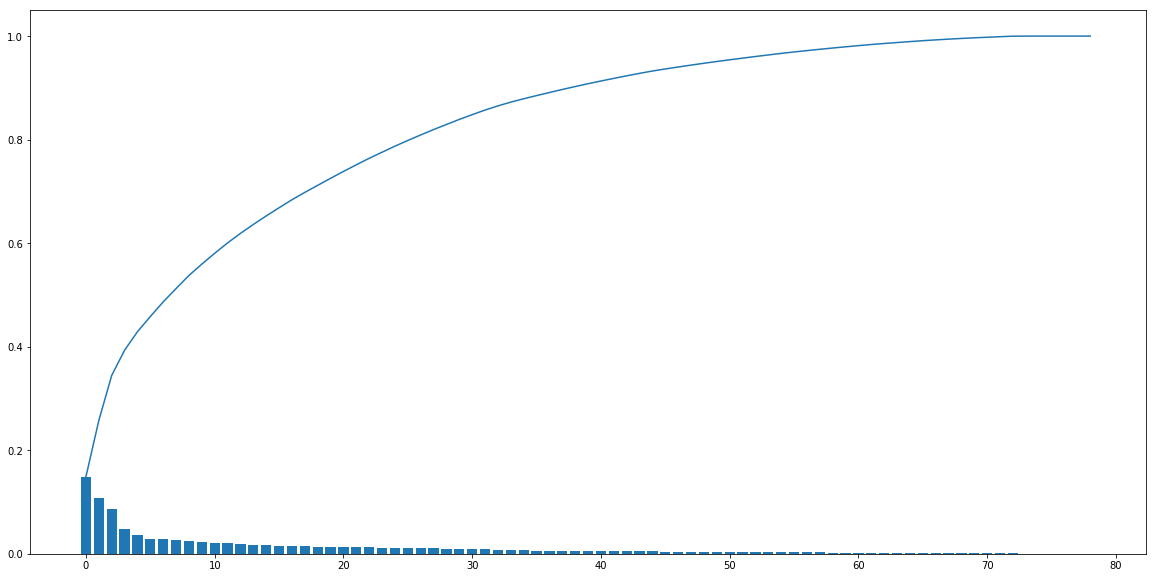

In [56]:
# Investigate the variance accounted for by each principal component.

print('Amount of explained variance for each component:\n{}'.format(np.round(pca.explained_variance_)))
print('\nWith ratio:\n{}'.format(np.round(pca.explained_variance_ratio_, decimals=3)))

# plot variability of explained variance for each component
scree_plot(pca)

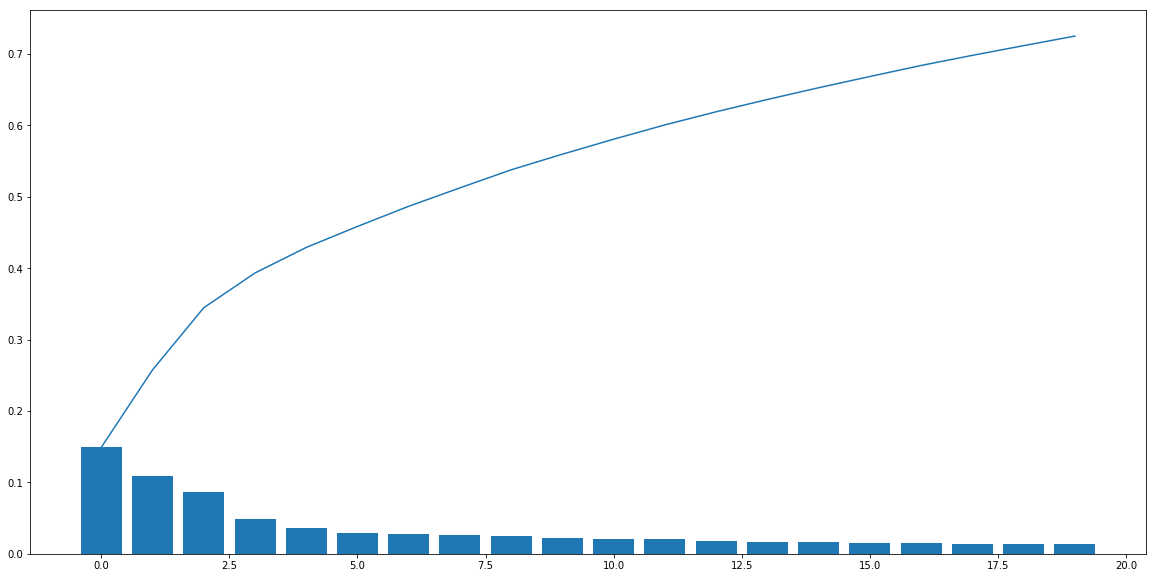

In [57]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca, pc_azdias = use_pca(scaled_azdias, n_component=20)
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

From 85 features that is kept for further analysis, we want to reduce the dimension of the data while retaining most information of the data. Hence, we utilize PCA from `sklearn.decomposition`.

As shown above, we first implement PCA to all the 85 features so that we know how the distribution of explained variance. It looks like the ratio of the explained variance has reached more than 0.7 with 16 features. So, based on this fact we decided to only expect 20 features after implementing PCA. That is, we pass 20 features as `n_components` in `PCA`.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [58]:
pca.components_[0]

array([ -8.52359749e-02,  -1.99921438e-01,   1.12896226e-01,
        -8.28090560e-02,   4.12644570e-02,   4.78551435e-02,
         1.65677968e-01,   3.30419109e-02,  -1.46993394e-01,
        -1.33139637e-01,   2.32312849e-03,   2.85794281e-02,
         5.62981839e-02,   8.11588419e-02,   5.93280023e-02,
        -4.45702979e-02,  -4.98930633e-02,  -4.84127804e-02,
         4.56582865e-02,   7.11261957e-02,   1.94965354e-02,
         2.97380584e-02,   4.80206393e-02,   8.54583992e-02,
         5.92138732e-02,  -9.69645066e-02,  -3.45427559e-03,
         1.97611906e-01,   6.04088980e-02,  -5.54719617e-02,
         1.34327325e-01,   3.51378695e-02,  -1.67197969e-01,
        -5.62050678e-02,   5.27760588e-02,  -8.68370238e-02,
        -2.11192742e-01,   1.26498887e-02,   1.32898297e-01,
         1.52043406e-01,  -2.11652256e-01,  -1.26684763e-01,
         1.94984966e-01,  -1.63795322e-01,  -1.16980800e-01,
         3.40401626e-02,  -2.23841834e-01,  -6.64062538e-02,
         5.59301789e-02,

In [59]:
# function to map the weights with corresponding feature names
def map_component(pca, comp):
    """map the weights to the corresponding feature names.
    parameters
    ----------
    pca: PCA object
    comp (int): element of the principle component
    """
    maps = {pca.feat_name[f]: pca.components_[comp, f] for f in range(pca.components_.shape[1])}
    sorted_maps = sorted(maps.items(), key=lambda k: k[1], reverse=True)
    
    return maps, sorted_maps    

In [60]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

maps, sorted_maps = map_component(pca, 0)
print('\nSorted pair of weights-component of PCA:')
for e in sorted_maps:
    print('{}: {}'.format(e[0], e[1]))


Sorted pair of weights-component of PCA:
PLZ8_ANTG3: 0.2244801473892341
PLZ8_ANTG4: 0.21752002697071837
PLZ8_BAUMAX: 0.21339287577018085
CAMEO_INTL_2015_WEALTH: 0.2005306696905115
HH_EINKOMMEN_SCORE: 0.19761190625735306
ORTSGR_KLS9: 0.1973216270579279
EWDICHTE: 0.19498496577428387
FINANZ_HAUSBAUER: 0.16567796755258143
PLZ8_ANTG2: 0.15285869490015494
KBA05_ANTG4: 0.1520434061851115
ARBEIT: 0.14099975139751245
ANZ_HAUSHALTE_AKTIV: 0.134327325399834
RELAT_AB: 0.13358455264292438
KBA05_ANTG3: 0.13289829715353507
FINANZ_SPARER: 0.11289622594675673
GREEN_AVANTGARDE_0: 0.10500038598704468
SEMIO_PFLICHT: 0.0854583991517715
SEMIO_REL: 0.08115884193482026
SEMIO_RAT: 0.07112619574823134
W_KEIT_KIND_HH: 0.060408897990919294
SEMIO_MAT: 0.05932800231951384
SEMIO_TRADV: 0.05921387315932581
SEMIO_FAM: 0.05629818388103449
REGIOTYP: 0.05593017892696444
NATIONALITAET_KZ_2.0: 0.05337466170130542
OST_WEST_KZ: 0.05277605879346463
SEMIO_KAEM: 0.04802063931847071
FINANZ_UNAUFFAELLIGER: 0.04785514350949506
SE

In [61]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

maps, sorted_maps = map_component(pca, 1)
print('\nSorted pair of weights-component of PCA:')
for e in sorted_maps:
    print('{}: {}'.format(e[0], e[1]))


Sorted pair of weights-component of PCA:
SEMIO_ERL: 0.2728992587690478
ALTERSKATEGORIE_GROB: 0.2426175548074019
FINANZ_VORSORGER: 0.20514526544115216
SEMIO_KAEM: 0.18598600609606936
ANREDE_KZ_2: 0.17701440618087314
SEMIO_KRIT: 0.1764774066211239
SEMIO_LUST: 0.16769303109156122
SEMIO_DOM: 0.14238873411122904
RETOURTYP_BK_S: 0.12825362348215133
SHOPPER_TYP_3.0: 0.10950818315854043
FINANZ_HAUSBAUER: 0.09423607820128442
W_KEIT_KIND_HH: 0.07991552945484942
NATIONALITAET_KZ_1.0: 0.07399884940414775
WOHNDAUER_2008: 0.05449846828666155
FINANZ_MINIMALIST: 0.054122592780095805
EWDICHTE: 0.053956089005473176
ORTSGR_KLS9: 0.05255284415075724
PLZ8_ANTG3: 0.049638504154751066
PLZ8_ANTG4: 0.046380413696443294
PLZ8_BAUMAX: 0.04176919490595075
KBA05_ANTG4: 0.039715392089482215
ARBEIT: 0.036978980630839715
RELAT_AB: 0.036780944250430915
PLZ8_ANTG2: 0.03447681841847799
ANZ_HAUSHALTE_AKTIV: 0.03395751717730114
SHOPPER_TYP_2.0: 0.033276264393661575
CAMEO_INTL_2015_WEALTH: 0.032537680856068694
VERS_TYP_2.0

In [62]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

maps, sorted_maps = map_component(pca, 2)
print('\nSorted pair of weights-component of PCA:')
for e in sorted_maps:
    print('{}: {}'.format(e[0], e[1]))


Sorted pair of weights-component of PCA:
ANREDE_KZ_1: 0.30609994641615706
SEMIO_VERT: 0.2908675252463485
SEMIO_SOZ: 0.20015688061676448
FINANZ_MINIMALIST: 0.17093932363728648
FINANZ_VORSORGER: 0.1647871237050256
ALTERSKATEGORIE_GROB: 0.1640829714278998
SEMIO_FAM: 0.156939588538656
RETOURTYP_BK_S: 0.1473294510418998
SEMIO_KULT: 0.1311312324297935
SEMIO_LUST: 0.11961374005046668
W_KEIT_KIND_HH: 0.10738119232930352
SHOPPER_TYP_0.0: 0.09038368917192831
ORTSGR_KLS9: 0.06479632217655422
EWDICHTE: 0.0640970197439625
NATIONALITAET_KZ_1.0: 0.06147824810797447
PLZ8_BAUMAX: 0.06102860362991481
PLZ8_ANTG3: 0.06077071455791573
PLZ8_ANTG4: 0.06031725399435241
WOHNDAUER_2008: 0.048703624759172004
GREEN_AVANTGARDE_1: 0.046526381521335286
ARBEIT: 0.04573367005666124
VERS_TYP_2.0: 0.04374510207912372
RELAT_AB: 0.043083137386628466
PLZ8_ANTG2: 0.04071802690671201
KBA05_ANTG4: 0.04009779443721136
CAMEO_INTL_2015_WEALTH: 0.0356834547669342
ANZ_HAUSHALTE_AKTIV: 0.035120888684694006
SHOPPER_TYP_1.0: 0.03051

### Discussion 2.3: Interpret Principal Components

Above observation shows the first three principle components and its weights corresponding to each features in the dataset. The weigths are sorted from higher to lower values and map them with their corresponding features.

On the first PC, we have `PLZ8_ANTG3` for the highest weight with positivie sign and `PLZ8_ANTG1` lowest weight with negative sign. Referring back to `Data_Dictionary.md`, having an opposite sign of weights mean those two features have negative correlation. As `PLZ8_ANTG3` increases, then `PLZ8_ANTG1` will decreases, and vice versa. For the second element of principle component, as `SEMIO_ERL` represent _event-oriented_ personality,  it works as expected that it will correlate negatively with `SEMIO_REL`, which represent religous typology. Lastly, `ANREDE_KZ_1` that represent person gender of _male_ correlate with `ANREDE_KZ_2`that represent a _female_.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [63]:
from sklearn.cluster import KMeans

In [64]:
# Over a number of different cluster counts...

kmean_score = []
for num_k in range(1,21):
    # run k-means clustering on the data and...
    print('Perform k-Means with {} cluster(s)..'.format(num_k))
    model = KMeans(n_clusters=num_k, random_state=40)
    model.fit(pc_azdias)
    # compute the average within-cluster distances.
    kmean_score.append(np.abs(model.score(pc_azdias)))
    

Perform k-Means with 1 cluster(s)..
Perform k-Means with 2 cluster(s)..
Perform k-Means with 3 cluster(s)..
Perform k-Means with 4 cluster(s)..
Perform k-Means with 5 cluster(s)..
Perform k-Means with 6 cluster(s)..
Perform k-Means with 7 cluster(s)..
Perform k-Means with 8 cluster(s)..
Perform k-Means with 9 cluster(s)..
Perform k-Means with 10 cluster(s)..
Perform k-Means with 11 cluster(s)..
Perform k-Means with 12 cluster(s)..
Perform k-Means with 13 cluster(s)..
Perform k-Means with 14 cluster(s)..
Perform k-Means with 15 cluster(s)..
Perform k-Means with 16 cluster(s)..
Perform k-Means with 17 cluster(s)..
Perform k-Means with 18 cluster(s)..
Perform k-Means with 19 cluster(s)..
Perform k-Means with 20 cluster(s)..


In [65]:
print('list of kMeans score:\n{}'.format(kmean_score))

list of kMeans score:
[44672855.496426441, 37776057.90993531, 34761660.730590813, 32302626.176881067, 30504513.497850824, 29251880.917962953, 28073921.324768212, 26653219.259195328, 25800596.729992434, 25185625.859839741, 24725371.464125849, 24151620.948258515, 23787711.901715502, 23404311.891098842, 23105941.161862615, 22514320.326784793, 22527780.994144678, 21960101.987270802, 21735362.96390504, 21471512.517876863]


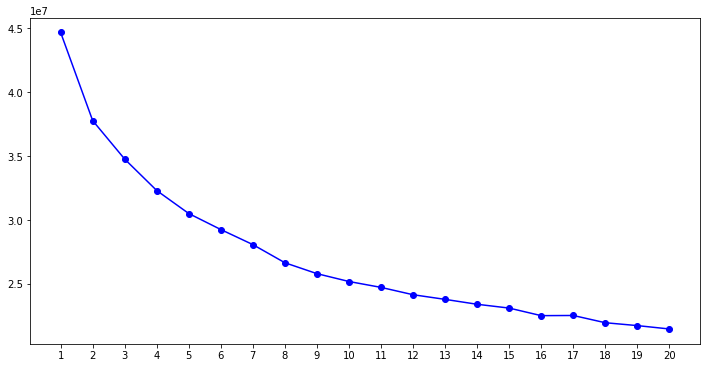

In [66]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(12,6))
plt.plot(range(1, 21), kmean_score, '-bo')
plt.xticks(range(1, 21))
plt.show()

In [67]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmean = KMeans(n_clusters=10)
cluster_azdias = kmean.fit_predict(pc_azdias)

In [68]:
print(cluster_azdias)
print(np.unique(cluster_azdias))

[9 2 2 ..., 5 3 4]
[0 1 2 3 4 5 6 7 8 9]


### Discussion 3.1: Apply Clustering to General Population

This step produces clusters for `scaled_azdias` dataset. To be able to find a right number of clusters, first we created a __scree_plot__ that plot the average distances for all possibility number of cluster, in this scheme, ranging from 1 to 20 clusters. Based on the __scree_plot__ above, cluster 10 and cluster 11 show there's only a slight difference on average distance of each clusters, and hence we decided to use 10 number of clusters to cluster the `scaled_azdias` dataset.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [69]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [70]:
display(customers.head())
print(customers.shape)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


(191652, 85)


In [71]:
# clean the customer dataset
processed_customer = clean_data(customers)

converting missing values to NaNs..

removing outliers.. with outliers:
['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

dropping rows with missing value..
new shape after dropping rows and column outliers: (139068, 79)

dropping multi-level categorical features..
new shape: (139068, 68)

encode binary nonnumeric categorical feature..
[DONE] new shape: (139068, 68)

encode remaining categorical features..
new shape of the dataset: (139068, 77)

encode mixed-type feature: PRAEGENDE_JUGENDJAHRE..
encoding mixed-type feature: CAMEO_INTL_2015..
[DONE] new shape (139068, 79).. with new features:
['ALTERSKATEGORIE_GROB', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_D

In [72]:
processed_customer.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOVE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,4.0,5,1,5,1,2,2,1.0,20.0,5.0,...,0,1,1,0,1,0,50.0,0.0,1.0,3.0
1,4.0,5,1,5,1,4,4,2.0,13.0,3.0,...,0,0,1,0,0,1,50.0,0.0,3.0,4.0
2,4.0,5,1,5,2,1,2,2.0,NaN,NaN,...,0,0,1,0,1,0,40.0,1.0,2.0,4.0
3,3.0,3,1,4,4,5,2,3.0,31.0,10.0,...,0,0,1,0,0,1,70.0,1.0,4.0,1.0
4,3.0,5,1,5,1,2,3,3.0,17.0,5.0,...,0,0,1,0,0,1,50.0,0.0,3.0,4.0


In [76]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
imputed_customer = pd.DataFrame(imputer.transform(processed_customer), columns=processed_customer.columns)
print('customer data after imputing missing values:')
display(imputed_customer.head(10))
scaled_customer = scaler.transform(imputed_customer)
pc_customer = pca.transform(scaled_customer)
clustered_customer = kmean.predict(pc_customer)

customer data after imputing missing values:


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOVE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
0,4.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,20.0,5.0,...,0.0,1.0,1.0,0.0,1.0,0.0,50.0,0.0,1.0,3.0
1,4.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,13.0,3.0,...,0.0,0.0,1.0,0.0,0.0,1.0,50.0,0.0,3.0,4.0
2,4.0,5.0,1.0,5.0,2.0,1.0,2.0,2.0,1.0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,40.0,1.0,2.0,4.0
3,3.0,3.0,1.0,4.0,4.0,5.0,2.0,3.0,31.0,10.0,...,0.0,0.0,1.0,0.0,0.0,1.0,70.0,1.0,4.0,1.0
4,3.0,5.0,1.0,5.0,1.0,2.0,3.0,3.0,17.0,5.0,...,0.0,0.0,1.0,0.0,0.0,1.0,50.0,0.0,3.0,4.0
5,4.0,5.0,1.0,5.0,1.0,1.0,2.0,2.0,20.0,5.0,...,0.0,0.0,1.0,0.0,1.0,0.0,50.0,0.0,2.0,3.0
6,4.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,20.0,5.0,...,0.0,1.0,1.0,0.0,1.0,0.0,50.0,0.0,1.0,5.0
7,4.0,2.0,2.0,5.0,1.0,1.0,5.0,2.0,6.0,2.0,...,0.0,1.0,1.0,0.0,0.0,1.0,40.0,1.0,5.0,5.0
8,3.0,5.0,2.0,4.0,1.0,3.0,1.0,3.0,28.0,8.0,...,0.0,0.0,1.0,0.0,0.0,1.0,70.0,0.0,1.0,5.0
9,4.0,5.0,1.0,5.0,1.0,3.0,2.0,1.0,13.0,3.0,...,0.0,0.0,1.0,0.0,1.0,0.0,50.0,0.0,1.0,4.0


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [77]:
# assign cluster as new column to corresponding data
cluster_azdias = pd.Series(cluster_azdias, name='cluster')
clustered_customer = pd.Series(clustered_customer, name='cluster')
pc_azdias = pd.DataFrame(pc_azdias, columns=[f'pc_{i}' for i in np.arange(pc_azdias.shape[1])])
pc_customer = pd.DataFrame(pc_customer, columns=[f'pc_{i}' for i in np.arange(pc_customer.shape[1])])

final_azdias = pd.concat([pc_azdias, cluster_azdias], axis=1)
final_customer = pd.concat([pc_customer, clustered_customer], axis=1)

In [78]:
print('final azdias demographic dataset:')
display(final_azdias.head(10))
print(final_azdias.shape)
print('')
print('final customer dataset:')
display(final_customer.head(10))
print(final_customer.shape)

final azdias demographic dataset:


,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_11,pc_12,pc_13,pc_14,pc_15,pc_16,pc_17,pc_18,pc_19,cluster
0,2.919929,-1.579190,-3.698424,0.108579,0.213205,-0.288916,3.589219,1.184146,15.426729,-2.403361,...,0.831587,-0.248818,0.315914,-0.086803,-0.246118,-0.421300,-1.347254,-0.923518,-3.001400,9
1,-0.673851,1.762475,-2.874963,1.461730,-2.706775,0.635330,-0.791852,-0.433781,-0.085600,-0.903409,...,0.501700,0.667167,-0.488221,-0.943611,-1.294713,1.920551,-0.791689,-0.141470,1.073770,2
2,-3.482441,1.974146,-0.347129,-2.275319,-1.039551,1.158557,-1.233489,0.126432,-0.079305,0.973079,...,-1.298733,-0.557272,-0.694476,0.081755,0.888811,-1.204846,1.171391,0.022820,-0.455545,2
3,0.202021,-0.775303,3.165927,1.882647,2.701526,-3.179614,0.030802,-2.298856,-0.355496,-0.474611,...,-0.148246,0.961786,-0.690291,-0.067636,-1.107948,1.461313,-0.607834,0.873328,0.818358,6
4,-0.825685,-1.513692,-1.846999,-2.705527,-2.181612,-1.680810,1.261532,-0.441302,-0.124585,-0.600918,...,1.717925,2.491613,2.166541,1.076981,0.932482,-2.495905,1.441058,-1.714863,-0.896943,5
5,0.033503,-1.965081,-4.479575,-1.071915,-2.208525,0.965924,-0.181976,-1.730910,-0.200227,0.632043,...,-0.774453,-0.145092,1.229165,2.162688,0.823968,-0.254241,-1.318877,0.491364,-0.214980,5
6,-1.163534,-4.136972,2.773203,0.488116,-3.200364,1.871296,-0.474569,-0.448999,-0.065916,-0.109982,...,2.030265,2.195992,0.336937,0.797104,-2.095006,-1.237218,0.357636,0.953824,0.432525,1
7,-1.596696,0.096851,1.737125,2.106677,-1.942826,-0.447665,-1.509672,2.355629,0.069582,-1.192914,...,0.448520,-0.886843,-1.285264,-0.712196,0.277100,1.926874,0.703541,-1.193778,0.562363,8
8,-0.808577,2.671386,-2.634843,1.062525,-2.643357,0.640455,-0.966338,2.046594,0.044733,-2.641656,...,-0.059737,-1.756311,-2.041520,-0.623804,-1.135425,0.575309,0.230863,-0.196027,0.897316,2
9,2.237234,3.287410,-0.623724,-2.481548,0.135286,-1.969738,-0.996113,-2.558466,-0.243857,-0.058386,...,0.097699,1.190235,0.219471,1.032114,-0.600050,0.904860,0.354356,-1.475614,-0.838710,0


(780153, 21)

final customer dataset:


,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_11,pc_12,pc_13,pc_14,pc_15,pc_16,pc_17,pc_18,pc_19,cluster
0,-5.816490,0.168643,4.290200,1.028426,-2.851287,2.898790,1.966676,-0.050861,-0.165849,-0.471069,...,0.339574,-0.243479,-1.069331,-0.891804,-0.274315,-0.397722,0.452756,-1.982284,1.830993,8
1,-0.567451,4.916199,0.749654,1.829582,-1.228741,-0.947778,-1.932105,0.358354,-0.069671,0.550342,...,-1.459306,-0.907217,-1.173107,1.078949,1.075855,-1.133143,1.136996,-2.735350,0.326679,0
2,-4.091336,-0.816131,2.806530,-3.509435,-1.214103,1.316048,-0.092774,0.374153,-0.044330,0.228608,...,1.109871,1.272297,-1.117128,-0.322096,0.457923,-1.364882,1.039719,-0.993998,0.512196,4
3,0.879200,-1.662565,1.106462,0.678920,2.329367,-2.065984,1.536431,-1.525816,-0.337464,0.023524,...,-2.206554,0.184690,-1.875900,2.016987,-0.168692,-0.614242,0.725909,0.436078,0.551465,6
4,-2.057171,0.327798,3.317422,2.607504,-2.832343,-1.834007,0.774230,-0.359399,-0.159379,-0.797523,...,-1.145735,-0.647555,1.423018,0.081316,0.342441,0.473847,-0.348789,-3.197636,-0.148476,8
5,-5.685524,-0.375998,3.183552,0.515667,-1.968712,1.059639,1.477543,0.065060,-0.145452,-0.512104,...,1.509948,0.997706,0.215480,-0.906798,0.953065,-1.224036,0.524629,-2.345444,1.030062,8
6,-4.426437,0.501809,4.624770,2.267445,-1.422114,2.937940,-1.340893,-0.177472,-0.096452,-0.202890,...,0.795159,-0.294620,-0.540297,-0.509707,-0.598717,0.472828,-0.306537,-2.268974,0.977244,8
7,4.420823,6.667290,0.836562,-0.119628,-0.675714,0.579163,2.451541,4.475565,0.168231,-0.118885,...,1.013243,-0.337156,-0.635484,2.037868,0.865569,2.707521,0.974026,-0.188120,1.438821,0
8,-4.381251,-1.518187,2.318269,3.652245,-0.456424,-2.311279,1.047061,0.162420,-0.193598,-1.150063,...,0.384491,-0.643777,0.419314,-0.832735,-0.744676,0.201734,1.038218,-1.076674,0.768643,8
9,-4.944709,-1.816311,3.587862,1.474865,-2.628290,3.001796,-1.449093,1.351164,0.026876,-0.459643,...,1.098411,0.928070,-1.400974,-0.595321,0.008919,-0.854435,-0.020828,-1.435824,1.903677,8


(139068, 21)


In [83]:
# function to compare proportion of dat in each cluster
# for customer data and demographics data
def compare_cluster(data_pop, data_cust, indices=None):
    if indices is not None:
        data_pop = data_pop.iloc[indices, :]
    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.ylim(ymax=110000)
    sns.countplot(x='cluster', data=data_pop)
    plt.title('demographics data')
    plt.subplot(122)
    plt.ylim(ymax=110000)
    sns.countplot(x='cluster', data=data_cust)
    plt.title('customer data')
    plt.show()

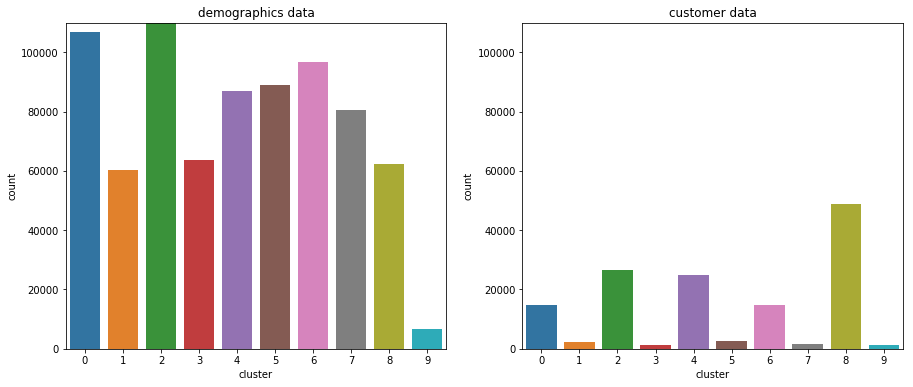

In [84]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

compare_cluster(final_azdias, final_customer)

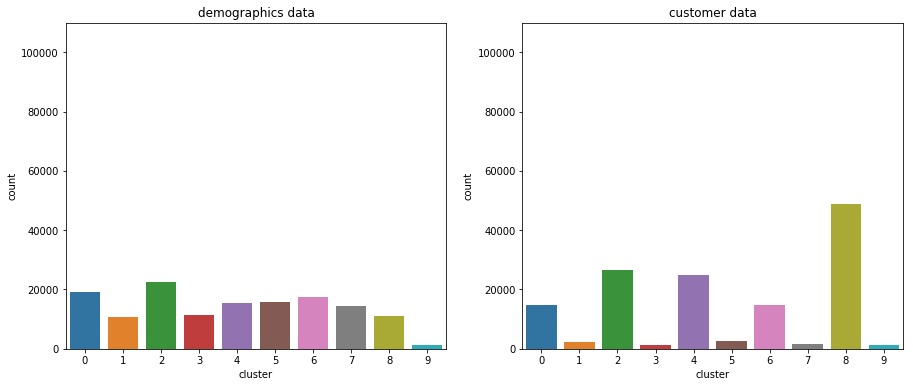

In [85]:
# choose randomly from demographics data
# so that it has the same size (rows) with customer data
rand_idx = np.random.choice(final_azdias.shape[0], final_customer.shape[0])

compare_cluster(final_azdias, final_customer, rand_idx)

[305711 435829 117952 ..., 313589 361136 695206]


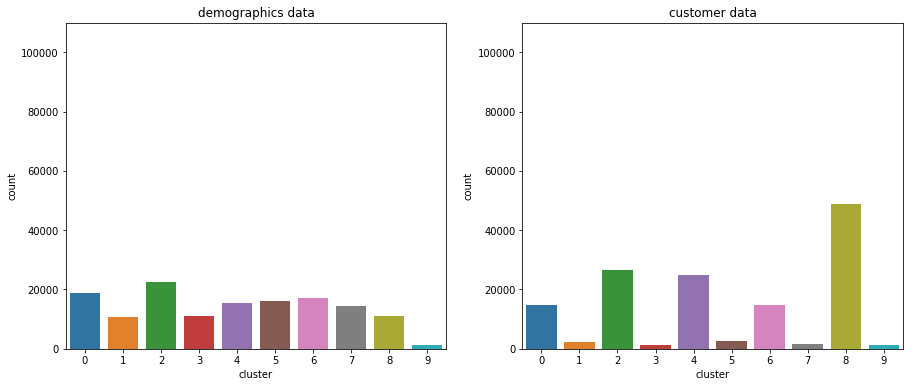

[128037 491755 470924 ..., 495631 368505 647157]


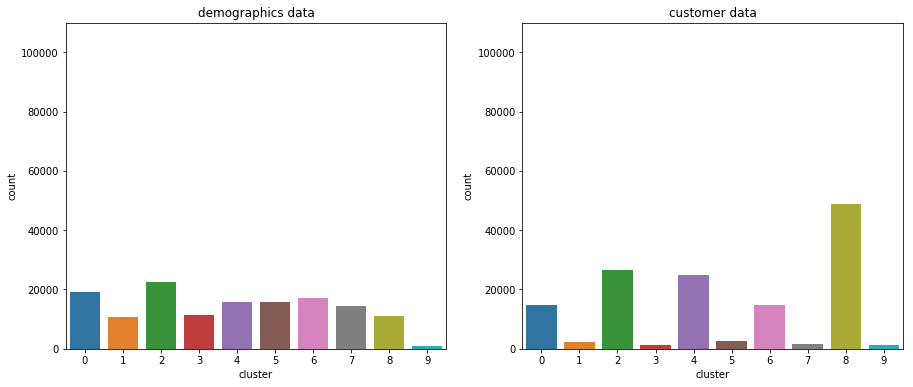

[100879 203245 620104 ..., 635411 111432 230981]


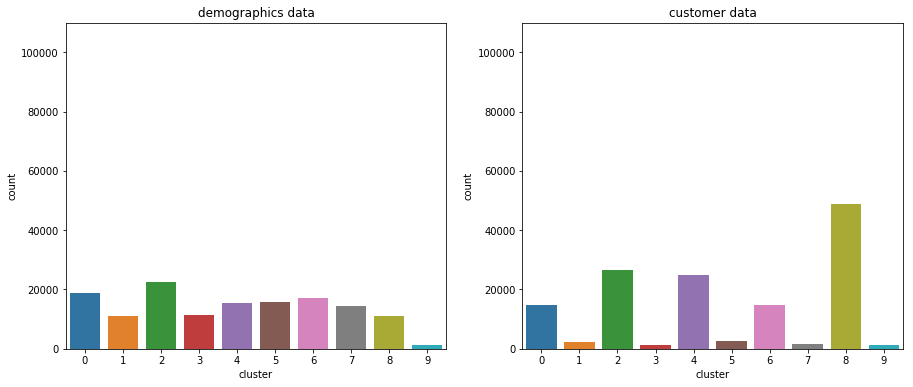

In [86]:
# compare proportion of demographics data and customer data
# with the new number of rows of demographics data
# based on choosen index of demographics data

for r in range(3):
    # generate random indices 5 times for demographics data index
    np.random.seed(r)
    rand_idx = np.random.choice(final_azdias.shape[0], final_customer.shape[0])
    print(rand_idx)
    compare_cluster(final_azdias, final_customer, rand_idx)

In [87]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_2_index = final_customer.loc[final_customer['cluster']==8].index
overrepresent = processed_customer.loc[cluster_2_index]

In [88]:
overrepresent.describe()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,SOHO_KZ_0.0,SOHO_KZ_1.0,VERS_TYP_1.0,VERS_TYP_2.0,PRAEGENDE_JUGENDJAHRE_GEN,PRAEGENDE_JUGENDJAHRE_MOVE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
count,48860.000000,48924.000000,48924.000000,48924.000000,48924.000000,48924.000000,48924.000000,48621.000000,46504.000000,46516.000000,...,48924.000000,48924.000000,48924.0,48924.0,48924.000000,48924.000000,48578.000000,48578.000000,48842.000000,48842.000000
mean,3.603090,4.864770,1.253250,4.711246,1.212084,1.836522,2.107187,1.841097,28.903105,8.536160,...,0.090078,0.375705,1.0,0.0,0.576956,0.416851,58.678826,0.490778,2.044245,3.706953
std,0.585297,0.403147,0.576226,0.656692,0.585432,0.875255,0.854713,0.835188,11.020032,3.784068,...,0.286297,0.484309,0.0,0.0,0.494047,0.493043,13.345599,0.499920,1.218173,1.122141
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,1.0,0.0,0.000000,0.000000,40.000000,0.000000,1.000000,1.000000
25%,3.000000,5.000000,1.000000,5.000000,1.000000,1.000000,2.000000,1.000000,20.000000,5.000000,...,0.000000,0.000000,1.0,0.0,0.000000,0.000000,50.000000,0.000000,1.000000,3.000000
50%,4.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,2.000000,35.000000,11.000000,...,0.000000,0.000000,1.0,0.0,1.000000,0.000000,60.000000,0.000000,2.000000,4.000000
75%,4.000000,5.000000,1.000000,5.000000,1.000000,2.000000,2.000000,3.000000,40.000000,12.000000,...,0.000000,1.000000,1.0,0.0,1.000000,1.000000,70.000000,1.000000,3.000000,4.000000
max,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,40.000000,12.000000,...,1.000000,1.000000,1.0,0.0,1.000000,1.000000,90.000000,1.000000,5.000000,5.000000


In [ ]:
overrepresent['GEBAEUDETYP_RASTER']

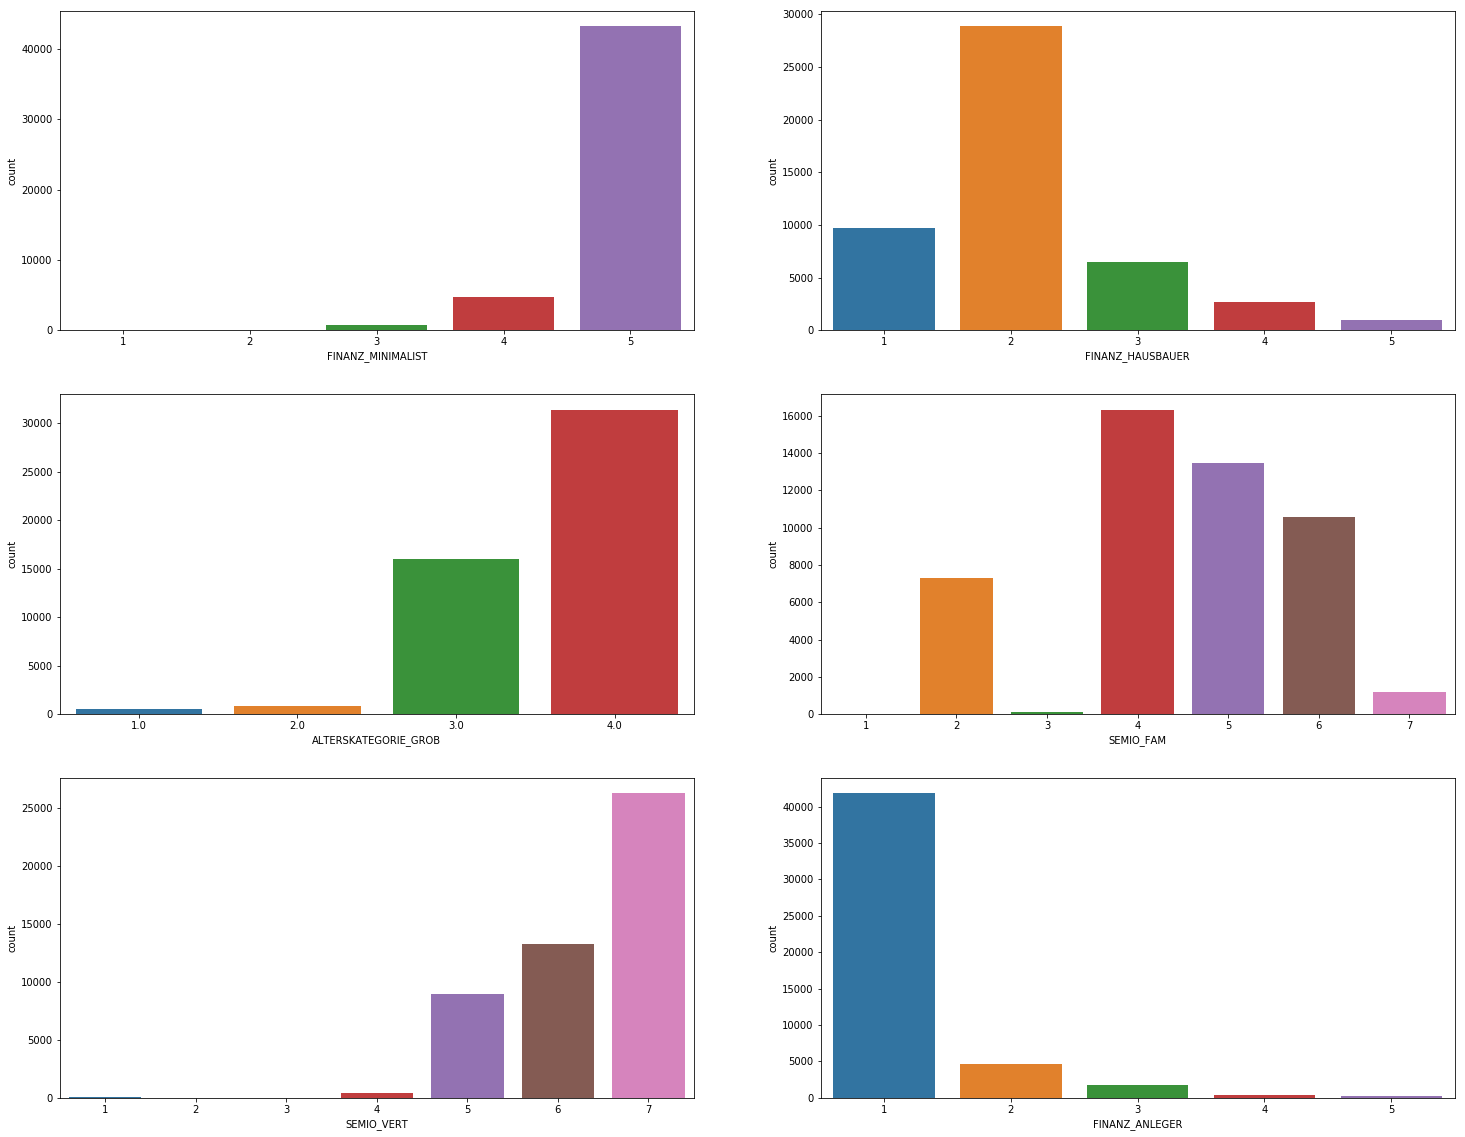

In [109]:
plt.figure(figsize=(25, 20))
plt.subplot(321)
sns.countplot(overrepresent['FINANZ_MINIMALIST'])
plt.subplot(322)
sns.countplot(overrepresent['FINANZ_HAUSBAUER'])
plt.subplot(323)
sns.countplot(overrepresent['ALTERSKATEGORIE_GROB'])
plt.subplot(324)
sns.countplot(overrepresent['SEMIO_FAM'])
plt.subplot(325)
sns.countplot(overrepresent['SEMIO_VERT'])
plt.subplot(326)
sns.countplot(overrepresent['FINANZ_ANLEGER'])
plt.show()

In [113]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_1_index = final_customer.loc[final_customer['cluster']==1].index
underrepresent = processed_customer.loc[cluster_1_index]

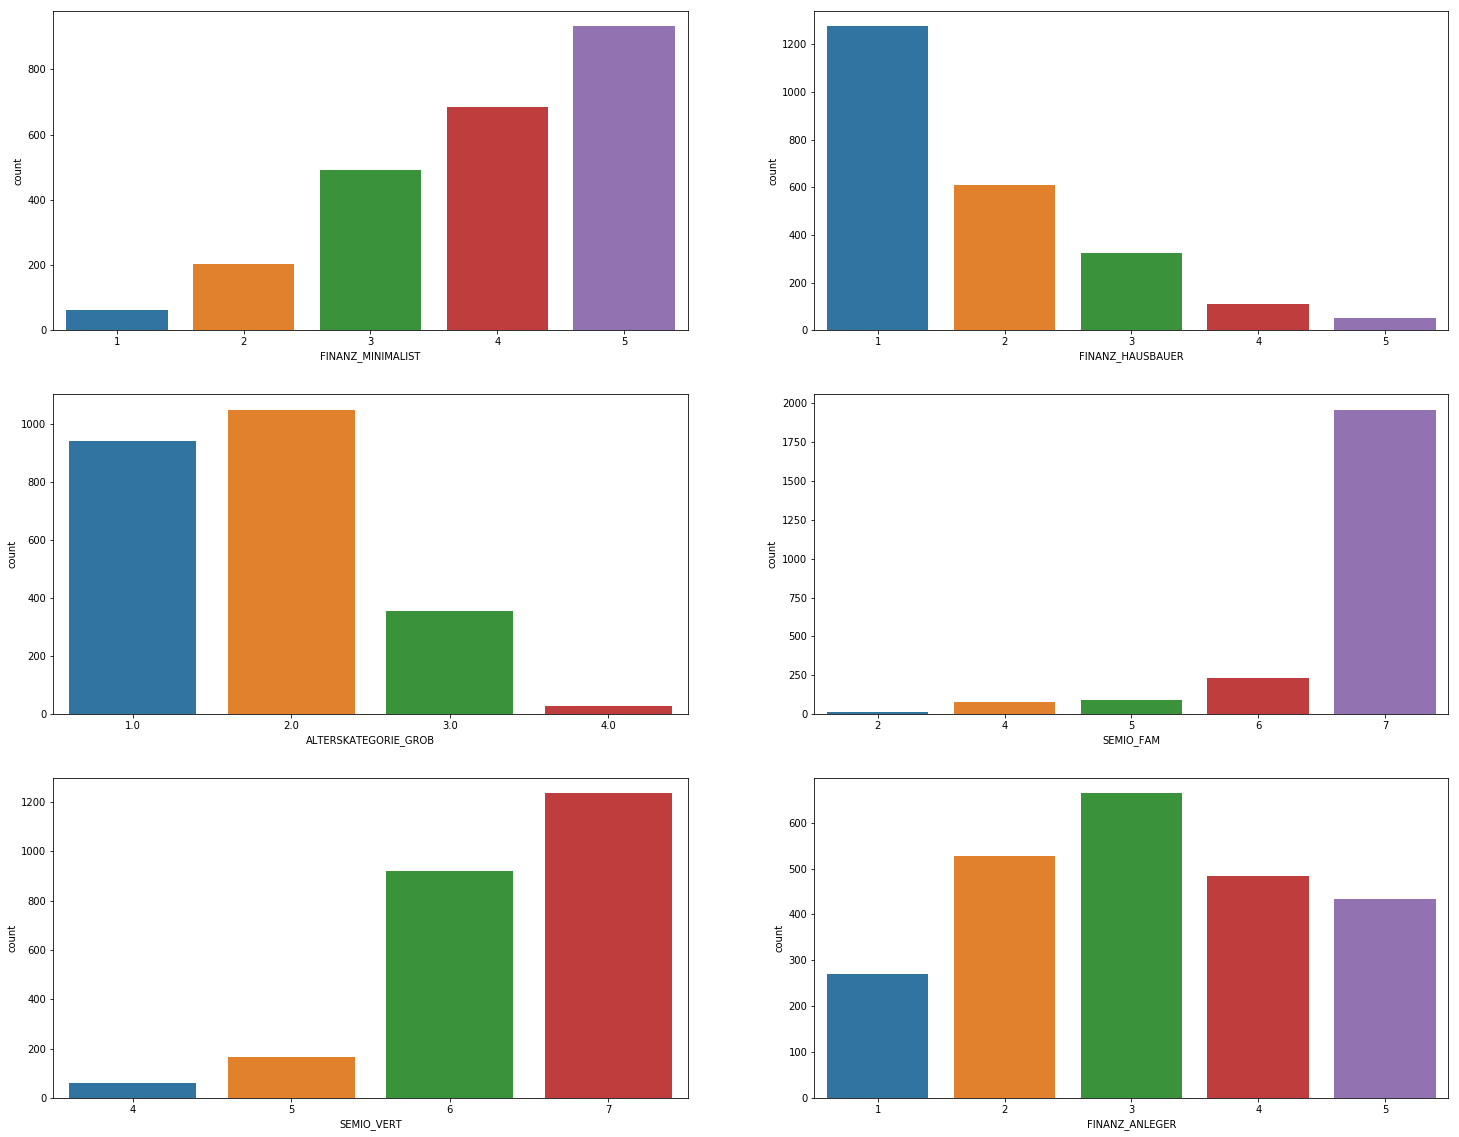

In [114]:
plt.figure(figsize=(25, 20))
plt.subplot(321)
sns.countplot(underrepresent['FINANZ_MINIMALIST'])
plt.subplot(322)
sns.countplot(underrepresent['FINANZ_HAUSBAUER'])
plt.subplot(323)
sns.countplot(underrepresent['ALTERSKATEGORIE_GROB'])
plt.subplot(324)
sns.countplot(underrepresent['SEMIO_FAM'])
plt.subplot(325)
sns.countplot(underrepresent['SEMIO_VERT'])
plt.subplot(326)
sns.countplot(underrepresent['FINANZ_ANLEGER'])
plt.show()

### Discussion 3.3: Compare Customer Data to Demographics Data

We have done clsutering analysis for two datasets `Udacity_AZDIAS_Subset.csv` and `Udacity_CUSTOMERS_Subset.csv`. First thing to do is we __scale__ all the datasets sot that their values are in the same range, with mean 0 and deviation 1. Second, we reduce data dimensionality from 85 feautres to only __20 latent features__ but more intuitive features but still represent the whole original data well, using Principle Component Analysis (`PCA` in Scikit-learn). After that, we cluster the data using `KMeans` of scikit-learn library and decided to cluster the data into __10 clusters__. Before we predict the cluster of `Udacity_CUSTOMERS_Subset`, we first _fit_ it to `Udacity_AZDIAS_Subset` dataset and then _predict_ the cluster of customer data based on centroids formed from previous fitting. Finally, if we pick each individual from demographics data randomly so that it matches number of individual in customer data, that is __139068 inviduals__, we could pull some insights that there are overrepresented clusters and underrepresented clusters in customer data. The overrepresented clusters mean that the company should spend more resources targeting this customer segments, and do, at least, conversely with the underrepresented clusters. Further analysis are provided below.

For cluster that could be a promising customer target (__overrrepresented__), the segments have some identification or properties:
1. From `FINANZ_MINIMALIST` feature that represent individual low financial interest level of individual financial topology, individual in this cluster tends to have very high financial interest. Moreover, individual also have high home ownership level represented by `FINANZ_HAUSBAUER`.
2. From `ALTERSKATEGORIE_GROB` and `SEMIO_FAM`, company should target individual older than 45 years old since __45-60__ and __> 60__ category have dominant proportion, and also have average affinity of familiy-minded personality.
3. Individual in this cluster, based on `FINANZ_ANLEGER`, typically would like to invest or act as investor, and hence make them worth to be a targeted customer.

For cluster that should not be targeted by the company (__underrepresented__), individual in this cluster also have some identifications or properties to look at:
1. From `FINANZ_MINIMALIST` and `FINANZ_HAUSBAUER` feature, individuals in this cluster have more diverse financial typology but still tends to have same behaviour with the _overrepresented_ one.
2. This cluster is dominated by younger individuals than overrepresented cluster, that is __less than 30 years old__ and between __30 and 45__, and have high affinity of family-minded personality.
3. Unlike overrepresented cluster, the tendency  of individuals of acting as investor or just like to invest is normally distributed and at average level. Hence, it's more like fifty-fifty to target this segment.

Based on above analysis, company should target individuals that have similar properties in overrepresented cluster than underrepresented cluster. Further action for unerrepresented cluster, if the company want to be more focused on younger individuals, the company could offer lower prices consider that these segments have low financial interest.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.